In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [74]:
pp_train = pd.read_csv("pp_train.csv")
pp_class = pp_train.copy()


### Preprocessing delle variabili

Mapping variabile target

In [75]:

y = np.array(pp_class['titleType'])  # Il target originale

# Creiamo un dizionario che associa ogni categoria a un numero
y_map = {title: idx for idx, title in enumerate(pp_class['titleType'].unique())}

#aggiungo una nuova colonna
pp_class['titleType_encoded'] = pp_class['titleType'].map(y_map)

print(y_map)  # Per vedere la mappatura delle categorie

{'tvEpisode': 0, 'videoGame': 1, 'movie': 2, 'tvSeries': 3, 'video': 4, 'tvMiniSeries': 5, 'short': 6, 'tvMovie': 7, 'tvSpecial': 8, 'tvShort': 9}


##### info variabili

In [76]:
#studio variabili (non ho messo le 28 is_genere)
pp_class[['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes', 'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits', 'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins', 'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
          #'countryOfOrigin', 
       'fill_runtimeMinutes', 'titleType_encoded']].head(3)

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,criticReviewsTotal,titleType,awardNominationsExcludeWins,canHaveEpisodes,isAdult,numRegions,userReviewsTotal,fill_runtimeMinutes,titleType_encoded
0,Neogenic Nightmare Chapter 3: Hydro-Man,8,1995,1995.0,NaN,0.0,779,1,0,21,1,tvEpisode,0,False,0,1,0,40.0,0
1,Looping,6,1982,1982.0,NaN,0.0,11,1,0,1,0,videoGame,0,False,0,1,0,28.0,1
2,Idealnaya para,6,1992,1992.0,NaN,0.0,38,1,0,24,0,movie,0,False,0,1,1,90.0,2


In [77]:
pp_class.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
       'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
       'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
       'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
       'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
       'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe', 'titleType_encoded'],
      dtype='object')

gestione country of origin  -> già sul train -> codice su modifiche_test

Conversione CanHaveEpisodes in binaria 0/1

In [78]:
pp_class['canHaveEpisodes'] = pp_class['canHaveEpisodes'].astype(int)

Rimuoviamo titleType dato che è già stata mappata + originaltitle e runtimeminutes non filled

In [79]:
column2drop = ['originalTitle', 'runtimeMinutes', 'titleType']
pp_class.drop(column2drop, axis=1, inplace=True)

END YEAR-> gaia non l'ha usato ad es, io ho fatto fill Nan ma er tutto

In [80]:
# Riempi i valori mancanti di 'endYear' con quelli di 'startYear' 
# -> DA VEDERE PERCHE' FATTO COME IN TEORIA HA FATTO BRUNO LASCIA COMUNQUE NAN
pp_class['endYear'].fillna(pp_class['startYear'], inplace=True)

#OPPURE RIMUOVI
#pp_class= pp_class.drop(["endYear"], axis=1)

BINARIZZAZIONE -> da capire

In [81]:
#binarizzazione (0 / >0) per le variabili con tanti zeri (consigliato per NB)
    # Alternativa: Se vuoi mantenere i valori numerici, puoi discretizzare in fasce (es. 0, 1-5, >5).
pp_class['awardWins_bin'] = (pp_class['awardWins'] > 0).astype(int)
pp_class['totalVideos_bin'] = (pp_class['totalVideos'] > 0).astype(int)
pp_class['awardNominations_bin'] = (pp_class['awardNominationsExcludeWins'] > 0).astype(int)

### ? Encoding di titletype per multiclass classification task

In [82]:
# Extract target (y)
y_train = pp_class["titleType_encoded"].values  # Convert directly to NumPy

### creazione array di valori -> da cui scegliere feature da usare

In [83]:
#X_train = pp_class.values
X_train = pp_class[['rating', 'startYear', 'awardWins', 'numVotes', 'totalImages',
       'totalVideos', 'totalCredits', 'criticReviewsTotal',
       'awardNominationsExcludeWins', 'canHaveEpisodes', 'isAdult',
       'numRegions', 'userReviewsTotal', 
       'endYear',
       #'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy', 'is_Family', 'is_Mystery',  'is_Talk-Show', 'is_Drama', 'is_Sport', 'is_War', 'is_Horror','is_Animation', 
       'fill_runtimeMinutes', 
       'is_from_Oceania','is_from_North America', 'is_from_South America', 'is_from_Asia', 'is_from_Africa', 'is_from_Europe', 
       'awardWins_bin', 'totalVideos_bin', 'awardNominations_bin']].values


### Splitting in validation

In [84]:

X_train2, X_val, y_train2, y_val = train_test_split(
     X_train, y, test_size=0.2, random_state=32
)

# X_train2 = training set --> 80% di X_train
# X_val = validation set --> 20% di X_train
# y_train2 e y_val sono i target corrispondenti (etichette) per i dati di addestramento e validazione

### Normalization

capire se log su tutte o no -> penso di si

In [85]:
X_train2_log = np.log1p(X_train)
X_val_log= np.log1p(X_val)

In [86]:

standardsc = StandardScaler()

# # Fitta e trasforma il training set in un solo passaggio
X_train2_standardsc = standardsc.fit_transform(X_train2_log)
X_val_standardsc = standardsc.fit_transform(X_val_log)

# # Trasforma il test set (senza rifittare!)
# # X_test_standardsc = standardsc.transform(X_test)

In [87]:
# minmax = MinMaxScaler()

# # Fitta e trasforma il training set in un solo passaggio
# X_train2_minmax = minmax.fit_transform(X_train2_log)
# X_val_minmax = minmax.fit_transform(X_val_log)


# # Trasforma il test set (senza rifittare!)
# #X_test_minmax = minmax.transform(X_test)



In [88]:
X_train2_tr = X_train2_standardsc
X_val_tr = X_val_standardsc

## NAIVE BAYES

In [89]:
clf = GaussianNB()

In [90]:
clf.fit(X_train2, y_train2)

GaussianNB()

In [91]:
y_pred = clf.predict(X_val)
y_pred

array(['tvSeries', 'tvSpecial', 'tvSpecial', ..., 'tvEpisode',
       'tvEpisode', 'short'], dtype='<U12')

In [92]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       movie       0.92      0.18      0.30      1121
       short       0.63      0.66      0.65       501
   tvEpisode       0.58      0.81      0.67       936
tvMiniSeries       0.12      0.22      0.16        37
     tvMovie       0.10      0.21      0.13       173
    tvSeries       0.58      0.12      0.20       268
     tvShort       0.04      0.60      0.08        10
   tvSpecial       0.02      0.29      0.04        28
       video       0.34      0.36      0.35       163
   videoGame       0.43      0.06      0.11        50

    accuracy                           0.44      3287
   macro avg       0.38      0.35      0.27      3287
weighted avg       0.65      0.44      0.44      3287



In [93]:
clf.predict_proba(X_val)
#prob che un record appartenga alle classi

array([[1.10101005e-006, 0.00000000e+000, 1.39778421e-283, ...,
        5.25629667e-141, 8.15840199e-192, 1.01315284e-258],
       [9.47961724e-008, 6.74394615e-065, 1.38305281e-007, ...,
        6.99010664e-001, 2.39169828e-001, 0.00000000e+000],
       [3.93018240e-006, 2.75781164e-029, 1.54133221e-003, ...,
        6.44068131e-001, 1.87231355e-001, 0.00000000e+000],
       ...,
       [2.96601680e-009, 3.80093775e-010, 9.16984478e-001, ...,
        7.94474987e-002, 1.69258111e-003, 6.49971206e-005],
       [2.35706715e-009, 4.55516734e-001, 5.40131602e-001, ...,
        2.91544860e-003, 3.76853051e-007, 4.00027869e-007],
       [2.24972670e-011, 8.64748798e-001, 4.71287980e-003, ...,
        5.81999655e-004, 1.07825227e-005, 2.54855223e-057]])

roc test

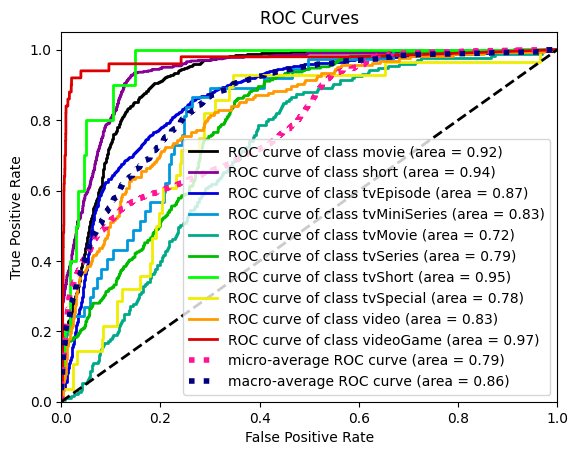

0.8598503432395302


In [94]:
plot_roc(y_val, clf.predict_proba(X_val))
plt.show()
print(roc_auc_score(y_val, clf.predict_proba(X_val), multi_class="ovr", average="macro"))